# OCT Image Denoising


Author: Xiaolong Du

### Autoencoder: denoising oct images

Removing noise from oct images.

In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import os

from torch.autograd import Variable

# Torchvision module contains various utilities, classes, models and datasets 
# used towards computer vision usecases
from torchvision import datasets
from torchvision import transforms

from torch.nn import functional as F

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Initializing Parameters**


In [0]:
crop_size = 450
train_size = 500
test_size =100

# hyper parameters
epoche_number = 10
batch_size = 10
learning_rate = 0.001
noise_level = 0.1



**Create the datasets**

In [4]:
transform=transforms.Compose([
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()])
s = time.time()

#cifar10_train = datasets.CIFAR10('./data.cifar10', train=True, download=True, transform=transform)
#cifar10_valid = datasets.CIFAR10('./data.cifar10', train=False, download=True, transform=transform)
oct_dataset = datasets.ImageFolder('gdrive/My Drive/OCT2017/train/',transform=transform)
oct_train_dataset, oct_test_dataset,_ = torch.utils.data.random_split(oct_dataset, [train_size, test_size,len(oct_dataset)-train_size-test_size])
del oct_dataset
e = time.time()
print(e-s)

1.2353806495666504


In [0]:
oct_dataset = datasets.ImageFolder('gdrive/My Drive/OCT2017/train/',transform=transform)

**Utility to display the original, noisy and denoised image**

In [0]:
def show_img(orig, noisy, denoised):
    fig=plt.figure()
    ### for 3 channel image
    orig = orig.swapaxes(0, 1).swapaxes(1, 2)
    noisy = noisy.swapaxes(0, 1).swapaxes(1, 2)
    denoised = denoised.swapaxes(0, 1).swapaxes(1, 2)
    
    ### for 1 channel image
    #orig = orig.squeeze()
    #noisy = noisy.squeeze()
    #denoised = denoised.squeeze()
    
    
    # Normalize for display purpose
    orig     = (orig - orig.min()) / (orig.max() - orig.min())
    noisy    = (noisy - noisy.min()) / (noisy.max() - noisy.min())
    denoised = (denoised - denoised.min()) / (denoised.max() - denoised.min())

    
    fig.add_subplot(1, 3, 1, title='Original')
    plt.imshow(orig,cmap='gray')
    
    fig.add_subplot(1, 3, 2, title='Noisy')
    plt.imshow(noisy,cmap = 'gray')
    
    fig.add_subplot(1, 3, 3, title='Denoised')
    plt.imshow(denoised,cmap = 'gray')
    
    #fig.subplots_adjust(wspace = 1)
    #plt.show()
    
# To test
#o = oct_train_dataset[80]
#a,b,c = o[0].size()
#print(a,b,c)
#show_img(o[0].numpy(),o[0].numpy(),o[0].numpy())



**Create the dataloader**

In [0]:
#cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=1)
#cifar10_valid_loader = torch.utils.data.DataLoader(cifar10_valid, batch_size=batch_size, shuffle=True, num_workers=1)
dataset_train_loader = torch.utils.data.DataLoader(oct_train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
dataset_valid_loader = torch.utils.data.DataLoader(oct_test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)





In [0]:
class DenoisingAutoencoder(nn.Module):
    
    def __init__(self):
    
        super(DenoisingAutoencoder, self).__init__()
        image_channels =3
        kernel_size =3
        padding =1
        encoder_layers = []
        decoder_layers = []
        channel_size_list = [image_channels,12, 24, 48]
        convlayer_numbers = len(channel_size_list)-1

        # Encoder laysers

        for i in range(convlayer_numbers):
            encoder_layers.append(nn.Conv2d(in_channels=channel_size_list[i], out_channels = channel_size_list[i+1],kernel_size=kernel_size,padding= padding))
            encoder_layers.append(nn.ReLU(inplace=True))

        self.encoder = nn.Sequential(*encoder_layers)

        # Maxpooling layer

        mp_kernel_size = 2
        self.mp_layer = nn.MaxPool2d(mp_kernel_size,return_indices=True)

        # Maxunpooling layer
         
        self.mup_layer = nn.MaxUnpool2d(mp_kernel_size)

        # Decoder layers

        for j in range(convlayer_numbers):
            k = convlayer_numbers-j
            decoder_layers.append(nn.ConvTranspose2d(in_channels=channel_size_list[k], out_channels = channel_size_list[k-1],kernel_size=kernel_size,padding= padding))
            decoder_layers.append(nn.ReLU(inplace=True))

        self.decoder = nn.Sequential(*decoder_layers)


    def forward(self,x):

        x = self.encoder(x)
        x,i = self.mp_layer(x)
        x = self.mup_layer(x,i)
        y = self.decoder(x)

        return y                                           

**The Denoising Autoencoder**

In [0]:
class DenoisingAutoencoder(nn.Module):
    
    def __init__(self):
    
        super(DenoisingAutoencoder, self).__init__()
                                                         

        self.conv1e = nn.Conv2d(3, 12, 3, padding=2)        
        self.conv2e = nn.Conv2d(12, 24, 3, padding=2)       
        self.conv3e = nn.Conv2d(24, 48, 3, padding=2)         
        self.mp1e   = nn.MaxPool2d(2, return_indices=True)

        self.mp1d = nn.MaxUnpool2d(2)
        self.conv3d = nn.ConvTranspose2d(48, 24, 3, padding=2)
        self.conv2d = nn.ConvTranspose2d(24, 12, 3, padding=2)
        self.conv1d = nn.ConvTranspose2d(12, 3, 3, padding=2)
        
        
        
    
    def forward(self, x):
        # Encoder
        x = self.conv1e(x)
        x = F.relu(x)
        x = self.conv2e(x)
        x = F.relu(x)
        x = self.conv3e(x)
        x = F.relu(x)

        x, i = self.mp1e(x)
        
         # Decoder
        x = self.mp1d(x, i)
        x = self.conv3d(x)
        x = F.relu(x)
        x = self.conv2d(x)
        x = F.relu(x)
        x = self.conv1d(x)
        x = F.relu(x)
        
        return x


In [0]:
class DnCNN(nn.Module):
    def __init__(self, depth=5, n_channels=12, image_channels=3, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []
        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out


In [0]:
autoencoder = DenoisingAutoencoder().cuda()
#autoencoder = DnCNN().cuda()
parameters = list(autoencoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [0]:
train_loss = []
valid_loss = []

epoche_number = 30
for i in range(epoche_number):
    
    # Let's train the model
    s = time.time()    
    total_loss = 0.0
    total_iter = 0
    autoencoder.train()
    for image, label in dataset_train_loader:
        noise = torch.randn(image.shape[0], 3, 450, 450) * noise_level
        image_n = torch.add(image, noise)
        image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()     
       

        optimizer.zero_grad()
        output = autoencoder(image_n)
        
        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()
        del image
        del image_n
        
        total_iter += 1
        total_loss += loss.item()
        
     
        
    # Let's record the validation loss
    
    total_val_loss = 0.0
    total_val_iter = 0
    autoencoder.eval()
    for image, label in dataset_valid_loader:
        
        noise = torch.randn(image.shape[0], 3, 450, 450) * noise_level
        image_n = torch.add(image, noise)
        
        image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()
        
        output = autoencoder(image_n)
        loss = loss_func(output, image)
        
        del image
        del image_n
        
        total_val_iter += 1
        total_val_loss += loss.item()
        
    
    train_loss.append(total_loss / total_iter)
    valid_loss.append(total_val_loss / total_val_iter)
    e = time.time()
    print("Iteration ", i+1)  
    print("Time elapsed:",e-s)

In [0]:
# Save the model
torch.save(autoencoder.state_dict(), "./gdrive/My Drive/Autoencoder4.pth")

In [0]:
# Load the model 

autoencoder.load_state_dict(torch.load("./gdrive/My Drive/Autoencoder4.pth"))

In [0]:

fig = plt.figure(figsize=(10, 7))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend()
plt.show()
train_loss

In [0]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_loss_p, label='Train loss')
plt.plot(valid_loss_p, label='Validation loss')
plt.legend()
plt.show()

###  Single image denoising

torch.Size([3, 450, 450])
19.996864317202206
28.75738815825009
28.48551160806762
<class 'torch.Tensor'>
torch.Size([3, 450, 450])
torch.Size([1, 3, 450, 450])
torch.Size([1, 3, 450, 450])


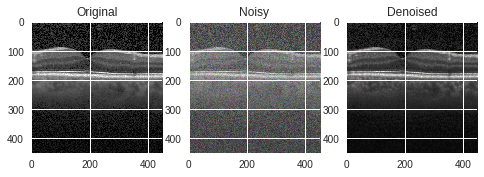

In [42]:
import random
from skimage.measure import compare_psnr

img, _ = random.choice(oct_dataset)
img    = img.resize_((1, 3, 450, 450))
noise  = torch.randn((1, 3, 450, 450)) * noise_level
img_n  = torch.add(img, noise)


img_n = Variable(img_n).cuda()
img_n2 = Variable(img).cuda()
denoised1 = autoencoder(img_n)
denoised2 = autoencoder(img_n2)

print(compare_psnr(img.cpu().numpy(),img_n.cpu().numpy()))
print(compare_psnr(img.cpu().numpy(),denoised1.data.cpu().numpy()))
print(compare_psnr(img.cpu().numpy(),denoised2.data.cpu().numpy()))
noise = denoised2[0].cpu()-img

print(type(noise))
print(denoised2[0].size())
print(img.size())
print(noise.size())
#noisy = noisy.swapaxes(0, 1).swapaxes(1, 2)
#print(noisy.shape)




show_img(img[0].numpy(), img_n[0].data.cpu().numpy(), denoised2[0].data.cpu().numpy())

In [46]:
from torchsummary import summary
summary(autoencoder, input_size=(3, 450, 450))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 450, 450]             336
              ReLU-2         [-1, 12, 450, 450]               0
            Conv2d-3         [-1, 24, 450, 450]           2,616
              ReLU-4         [-1, 24, 450, 450]               0
            Conv2d-5         [-1, 48, 450, 450]          10,416
              ReLU-6         [-1, 48, 450, 450]               0
         MaxPool2d-7  [[-1, 48, 225, 225], [-1, 48, 225, 225]]               0
       MaxUnpool2d-8         [-1, 48, 450, 450]               0
   ConvTranspose2d-9         [-1, 24, 450, 450]          10,392
             ReLU-10         [-1, 24, 450, 450]               0
  ConvTranspose2d-11         [-1, 12, 450, 450]           2,604
             ReLU-12         [-1, 12, 450, 450]               0
  ConvTranspose2d-13          [-1, 3, 450, 450]             327
             ReLU-14    